In [1]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Create a dataframe for crime & safety score data
df_score = pd.read_csv("/content/drive/My Drive/Police_Sentiment_Scores.csv")

In [4]:
df_all_crime = pd.read_csv("/content/drive/My Drive/Crimes_-_2001_to_Present_20240605.csv")

In [5]:
# Remove averaged data
df_score = df_score.dropna(subset=['SECTOR'])

In [94]:
# Create a Year column in the safety score dataset to simplify merging
df_score.loc[:, 'Year'] = df_score['START_DATE'].str[-4:]

In [7]:
# Change DISTRICT column to District to simplify merging
df_score = df_score.rename(columns={'DISTRICT': 'District'})

In [8]:
# Create a new crime dataFrame & score dataframe excluding rows where 'District' is NaN
df_all_crime = df_all_crime.dropna(subset=['District'])
df_score = df_score.dropna(subset=['District'])

# Exclude rows where the location of the crime is not given
df_all_crime = df_all_crime.dropna(subset=['Location'])

In [9]:
# Drop rows in crime dataframe where 'District' is 21 or 31 (no safety score data for those districts)
df_all_crime = df_all_crime[~df_all_crime['District'].isin([21, 31])]

In [10]:
# Specify violent crimes
violent_crime = ['ASSAULT', 'HOMICIDE', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 'ROBBERY', 'SEX OFFENSE', 'STALKING', 'KIDNAPPING', 'HUMAN TRAFFICKING', 'CRIM SEXUAL ASSAULT', 'DOMESTIC VIOLENCE']

# Drop rows that are not a violent crime
df_crime = df_all_crime[df_all_crime['Primary Type'].isin(violent_crime)]

In [11]:
# Determine the number of crimes in the dataset
df_crime.shape[0]

2390399

In [12]:
# Import census data
df_census_pop = pd.read_csv("/content/drive/My Drive/Population_by_2010_Census_Block_20240703.csv", dtype={'CENSUS BLOCK FULL':'Int64'})
df_census_shape = pd.read_csv("/content/drive/My Drive/CensusBlockTIGER2010_20240703.csv")

In [13]:
# Drop unnecessary columns
df_census_shape = df_census_shape.drop(columns=['STATEFP10', 'BLOCKCE10','TRACT_BLOC','TRACTCE10'])

In [14]:
# Merge the two data frames into one
df_census_pop = df_census_pop.rename(columns={'CENSUS BLOCK FULL': 'GEOID10'})
df_census = pd.merge(df_census_pop, df_census_shape, on='GEOID10')

In [15]:
# Rename columns to be more humanly readable
df_census.rename(columns={'GEOID10': 'GEO ID', 'TOTAL POPULATION': 'POPULATION', 'the_geom': 'SHAPE', 'COUNTYFP10': 'COUNTY', 'NAME10': 'BLOCK NAME'}, inplace=True)

In [16]:
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

# Convert WKT strings to geometry objects
df_census['geometry'] = df_census['SHAPE'].apply(wkt.loads)

# Convert DataFrame to GeoDataFrame
gdf_census = gpd.GeoDataFrame(df_census, geometry='geometry')

# Initialize an empty list to store simulated locations
simulated_locations = []

In [17]:
from pyproj import Proj

# Define a projection using EPSG:26971 (NAD83 / Illinois East) which outputs coordinates in meters
p = Proj("EPSG:26971", preserve_units=True)

# Transform geographic coordinates (longitude, latitude) to projected coordinates in meters
loc = p(-87.6396240000, 41.8363100000)  # Coordinates for a point in Chicago

# Print the coordinates in meters
print(loc)

(357620.1263479303, 574154.407556343)


In [18]:
# Extract the bounding box coordinates (minx, miny, maxx, maxy) from the geometry of the first row of the census DataFrame
minx, miny, maxx, maxy = df_census['geometry'][0].bounds

# Convert the minimum bounding box coordinates from geographic (longitude, latitude) to projected (meters) coordinates using EPSG:26971
minx_proj, miny_proj = p(minx, miny)
print(minx_proj, miny_proj)

# Convert the maximum bounding box coordinates from geographic (longitude, latitude) to projected (meters) coordinates using EPSG:26971
maxx_proj, maxy_proj = p(maxx, maxy)
print(maxx_proj, maxy_proj)

354688.78265256225 589253.8910233199
354755.44848764123 589358.4842501843


In [19]:
import numpy as np

# Generate simulated population location distribution
for _, row in gdf_census.iterrows():
    census_shape = row['geometry']
    population = row['POPULATION']
    minx, miny, maxx, maxy = census_shape.bounds

    for _ in range(population):
        while True:
            random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
            if census_shape.contains(random_point):
                # convert to x,y coordinate plane
                x, y = random_point.x, random_point.y
                px, py = p(x,y)
                px, py = px * (39.37/12), py * (39.37/12)
                random_point_proj = Point(px, py)
                simulated_locations.append({'location': random_point_proj, 'GEO ID': row['GEO ID']})
                break

In [20]:
# Convert simulated locations to a GeoDataFrame
gdf_simulated_locations = gpd.GeoDataFrame(simulated_locations, geometry='location')

# Convert crime data to a GeoDataFrame
gdf_violent_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime['X Coordinate'], df_crime['Y Coordinate']))

# List to store crime counts for each simulated location
violent_crime_counts = []

In [21]:
# Set the CRS to match the census data if not already set
if gdf_census.crs is None:
    gdf_census.crs = 'EPSG:4326'

gdf_simulated_locations.crs = gdf_census.crs

# Explode the GeoDataFrame to have one point per row
gdf_simulated_locations = gdf_simulated_locations.explode().reset_index(drop=True)

# Check and set the CRS for gdf_violent_crime
if gdf_violent_crime.crs is None:
    gdf_violent_crime.crs = 'EPSG:4326'

# Ensure both GeoDataFrames are in the same CRS
if gdf_simulated_locations.crs != gdf_violent_crime.crs:
    gdf_simulated_locations = gdf_simulated_locations.to_crs(gdf_violent_crime.crs)

In [22]:
# Define the distance to count crimes (2 city blocks)
distance = 402.336 # 1 city block is about 660 ft or 201.168 meters

In [23]:
# Split the GeoDataFrame into chunks
def split_dataframe(df, chunk_size):
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

In [24]:
# Initialize the spatial index for the crime GeoDataFrame
if gdf_violent_crime.sindex is None:
    gdf_violent_crime = gdf_violent_crime.set_geometry('geometry')
    gdf_violent_crime.sindex

In [25]:
# Function to count the number of crimes within a specified distance for each location in a chunk of simulated locations
def count_violent_crimes_in_chunks(simulated_locations_chunk, gdf_violent_crime, distance):
    chunk_violent_crime_counts = []
    for _, row in simulated_locations_chunk.iterrows():
        point = row['location']
        count = gdf_violent_crime.sindex.query(point, predicate='dwithin', distance=distance).size
        chunk_violent_crime_counts.append(count)
    return chunk_violent_crime_counts

In [26]:
# Define the chunk size
chunk_size = 100000

# Split the simulated locations GeoDataFrame into smaller chunks
chunks = split_dataframe(gdf_simulated_locations, chunk_size)

In [27]:
# Filter the GeoDataFrame to include only crimes from 2017 to 2023 (all safety score data is within these years)
filtered_gdf_violent_crime = gdf_violent_crime[(gdf_violent_crime['Year'] >= 2017) & (gdf_violent_crime['Year'] <= 2023)]

In [28]:
# Initialize an empty list to store crime counts for all chunks
violent_crime_counts = []

# Loop through each chunk of the simulated locations GeoDataFrame
for i, chunk in enumerate(chunks):
    # Print the current chunk being processed
    print(f"Processing chunk {i+1}/{len(chunks)}")

    # Count the number of violent within the specified distance for each point in the current chunk
    chunk_violent_crime_counts = count_violent_crimes_in_chunks(chunk, filtered_gdf_violent_crime, distance)

    # Extend the violent_crime_counts list with the counts from the current chunk
    violent_crime_counts.extend(chunk_violent_crime_counts)

Processing chunk 1/27
Processing chunk 2/27
Processing chunk 3/27
Processing chunk 4/27
Processing chunk 5/27
Processing chunk 6/27
Processing chunk 7/27
Processing chunk 8/27
Processing chunk 9/27
Processing chunk 10/27
Processing chunk 11/27
Processing chunk 12/27
Processing chunk 13/27
Processing chunk 14/27
Processing chunk 15/27
Processing chunk 16/27
Processing chunk 17/27
Processing chunk 18/27
Processing chunk 19/27
Processing chunk 20/27
Processing chunk 21/27
Processing chunk 22/27
Processing chunk 23/27
Processing chunk 24/27
Processing chunk 25/27
Processing chunk 26/27
Processing chunk 27/27


In [29]:
# Add crime counts to the GeoDataFrame
gdf_simulated_locations['violent_crime_counts'] = violent_crime_counts
gdf_simulated_locations.head()

,GEO ID,location,violent_crime_counts
0,170310310003002,POINT (1163848.939 1933309.28531),6
1,170310310003002,POINT (1163850.77934 1933268.38535),8
2,170310310003002,POINT (1163727.54683 1933569.5449),9
3,170310310003002,POINT (1163888.90778 1933367.96251),6
4,170310310003002,POINT (1163781.21537 1933302.92428),7


In [30]:
# Read the GeoJSON file into a GeoDataFrame
geojson_path = '/content/drive/My Drive/Boundaries - Police Districts (current).geojson'
gdf_district = gpd.read_file(geojson_path)

# Define the CRS
crs_3435 = "EPSG:3435"

# Reproject district GeoDataFrame to EPSG:3435
gdf_district = gdf_district.to_crs(crs_3435)
# Change DISTRICT column to District to simplify merging
gdf_district = gdf_district.rename(columns={'dist_num': 'District'})

In [31]:
# Read the GeoJSON file into a GeoDataFrame
geojson_path = '/content/drive/My Drive/Boundaries - Police Beats (current).geojson'
gdf_beats = gpd.read_file(geojson_path)

In [32]:
# Drop unneeded columns
gdf_beats = gdf_beats.drop(columns=['beat', 'district', 'sector'])

In [33]:
# Ensure sectors are of type int
gdf_beats['beat_num'] = gdf_beats['beat_num'].astype(int)
df_score['SECTOR'] = df_score['SECTOR'].astype(int)

In [34]:
# Transform beat numbers into their sector number (sectors are groups of beats)
gdf_beats['beat_num'] = gdf_beats['beat_num'] // 10 * 10

# Rename to sectors
gdf_beats = gdf_beats.rename(columns={'beat_num': 'SECTOR'})

In [35]:
# Dissolve geometries by 'SECTOR' to merge geometries with the same sector
gdf_sector = gdf_beats.dissolve(by='SECTOR')

# Reset index
gdf_sector = gdf_sector.reset_index()

In [36]:
# Remove rows where df_score and gdf_sector do not have matching sector information
df_score = df_score.loc[~df_score['SECTOR'].isin([2540, 2550])]
gdf_sector = gdf_sector.loc[gdf_sector['SECTOR'] != 3100]

In [37]:
# Merge df_score with gdf_sector
gdf_sector_scores = gdf_sector.merge(df_score, on='SECTOR', how='left')

# Verify the merge
gdf_sector_scores.head()

,SECTOR,geometry,ORG_LEVEL,CITY,AREA,District,SAFETY,S_RACE_AFRICAN_AMERICAN,S_RACE_ASIAN_AMERICAN,S_RACE_HISPANIC,...,T_RESPECT_SEX_MALE,T_RESPECT_EDUCATION_LOW,T_RESPECT_EDUCATION_MEDIUM,T_RESPECT_EDUCATION_HIGH,T_RESPECT_INCOME_LOW,T_RESPECT_INCOME_MEDIUM,T_RESPECT_INCOME_HIGH,START_DATE,END_DATE,Year
0,110,"POLYGON ((-87.62419 41.88882, -87.62403 41.888...",Other,chicago,area_3,1.0,46.17,38.22,41.29,29.00,...,86.46,80.17,87.86,82.43,65.39,85.95,91.82,09/01/2020,09/30/2020,2020
1,110,"POLYGON ((-87.62419 41.88882, -87.62403 41.888...",Other,chicago,area_3,1.0,67.95,61.48,62.59,74.16,...,85.20,75.83,93.88,90.24,71.45,92.38,93.71,06/01/2020,06/30/2020,2020
2,110,"POLYGON ((-87.62419 41.88882, -87.62403 41.888...",Other,chicago,area_3,1.0,59.08,67.86,45.93,55.21,...,58.95,48.81,63.78,71.27,55.87,61.21,56.15,01/01/2022,01/31/2022,2022
3,110,"POLYGON ((-87.62419 41.88882, -87.62403 41.888...",Other,chicago,area_3,1.0,49.01,52.07,43.41,51.02,...,77.41,67.80,74.43,68.98,58.76,72.27,71.81,10/01/2021,10/31/2021,2021
4,110,"POLYGON ((-87.62419 41.88882, -87.62403 41.888...",Other,chicago,area_3,1.0,47.58,35.43,58.07,37.53,...,47.81,25.25,55.64,70.59,36.07,53.57,75.79,07/01/2022,07/31/2022,2022


In [38]:
# Define the CRS
crs_3435 = "EPSG:3435"

# Reproject district GeoDataFrame to EPSG:3435
gdf_sector = gdf_sector.to_crs(crs_3435)

In [39]:
print(gdf_simulated_locations.crs)
print(gdf_sector.crs)

EPSG:4326
EPSG:3435


In [40]:
# Perform spatial join
gdf_simulated_locations_district = gpd.sjoin(
    gdf_simulated_locations, gdf_district, how='left', predicate='within'
)

# Verify the join results
print(gdf_simulated_locations_district.head())

<ipython-input-40-d6b44c41ce7a>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3435

  gdf_simulated_locations_district = gpd.sjoin(


            GEO ID                             location  violent_crime_counts  \
0  170310310003002    POINT (1163848.939 1933309.28531)                     6   
1  170310310003002  POINT (1163850.77934 1933268.38535)                     8   
2  170310310003002   POINT (1163727.54683 1933569.5449)                     9   
3  170310310003002  POINT (1163888.90778 1933367.96251)                     6   
4  170310310003002  POINT (1163781.21537 1933302.92428)                     7   

   index_right dist_label District  
0          1.0       20TH       20  
1          1.0       20TH       20  
2          1.0       20TH       20  
3          1.0       20TH       20  
4          1.0       20TH       20  


In [42]:
# Dataframe with computed commonly used crime metrics
df_metrics = pd.read_csv("/content/drive/My Drive/district_metrics.csv")
df_metrics.head()

,District,Number of Crimes,Avg. Safety Score,Avg. Danger Score,Population,Area,Crimes per Mile,Crimes per Sq. Mile,Crimes per Population
0,1,62174,62.195000,37.805000,62781,4.69,28709.285720,13256.716418,0.990331
1,2,124249,57.867387,42.132613,95439,7.52,45308.948322,16522.473404,1.301868
2,3,144866,51.392748,48.607252,75235,6.08,58750.920984,23826.644737,1.925513
3,4,155273,53.335090,46.664910,123575,27.27,29734.002598,5693.912725,1.256508
4,5,127480,53.596261,46.403739,74396,12.80,35631.743221,9959.375000,1.713533


In [43]:
# Aggregate crime counts by district
violent_crime_counts_by_district = gdf_simulated_locations_district.groupby('District')['violent_crime_counts'].sum().reset_index()

In [44]:
# Ensure they are of type int
violent_crime_counts_by_district['District'] = violent_crime_counts_by_district['District'].astype(int)
df_metrics['District'] = df_metrics['District'].astype(int)

# Merge crime counts with metrics
df_metrics = pd.merge(violent_crime_counts_by_district, df_metrics, on='District')
df_metrics

,District,violent_crime_counts,Number of Crimes,Avg. Safety Score,Avg. Danger Score,Population,Area,Crimes per Mile,Crimes per Sq. Mile,Crimes per Population
0,1,8832767,62174,62.195000,37.805000,62781,4.69,28709.285720,13256.716418,0.990331
1,10,11487222,119103,51.682342,48.317658,118093,7.87,42455.634380,15133.799238,1.008553
2,11,11374794,162186,50.677658,49.322342,70474,6.11,65613.432465,26544.353519,2.301359
3,12,8565524,104390,58.564730,41.435270,127869,9.68,33552.216767,10784.090909,0.816382
4,14,6150316,78373,61.938559,38.061441,117738,6.00,31995.643269,13062.166667,0.665656
5,15,9461929,114951,52.324550,47.675450,59458,3.82,58814.048080,30091.884817,1.933314
6,16,3763575,60819,67.219662,32.780338,199476,31.53,10831.217819,1928.924833,0.304894
7,17,5822181,59262,64.211622,35.788378,144096,9.62,19106.835657,6160.291060,0.411267
8,18,13499039,71719,62.599955,37.400045,117041,4.69,33116.757207,15291.897655,0.612768
9,19,11093514,77652,65.114414,34.885586,200786,8.58,26509.955697,9050.349650,0.386740


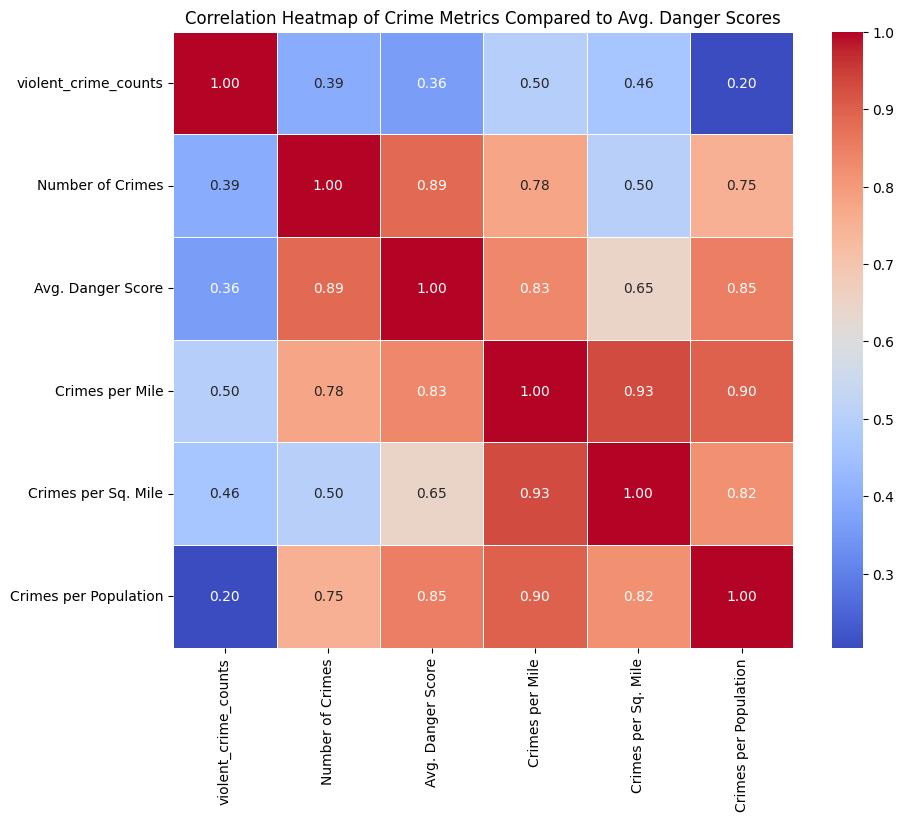

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the metrics for the heatmap
metrics = ['violent_crime_counts', 'Number of Crimes', 'Avg. Danger Score',
           'Crimes per Mile', 'Crimes per Sq. Mile', 'Crimes per Population']

# Filter the DataFrame to include only these metrics
selected_metrics_df = df_metrics[metrics]

# Calculate the correlation matrix
correlation_matrix = selected_metrics_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Crime Metrics Compared to Avg. Danger Scores")
plt.show()

In [46]:
# Perform spatial join
gdf_simulated_locations_sector = gpd.sjoin(
    gdf_simulated_locations, gdf_sector, how='left', predicate='within'
)

# Verify the join results
print(gdf_simulated_locations_sector.head())

<ipython-input-46-a5d68231f82a>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3435

  gdf_simulated_locations_sector = gpd.sjoin(


            GEO ID                             location  violent_crime_counts  \
0  170310310003002    POINT (1163848.939 1933309.28531)                     6   
1  170310310003002  POINT (1163850.77934 1933268.38535)                     8   
2  170310310003002   POINT (1163727.54683 1933569.5449)                     9   
3  170310310003002  POINT (1163888.90778 1933367.96251)                     6   
4  170310310003002  POINT (1163781.21537 1933302.92428)                     7   

   index_right  SECTOR  
0         57.0  2030.0  
1         57.0  2030.0  
2         57.0  2030.0  
3         57.0  2030.0  
4         57.0  2030.0  


In [47]:
# Aggregate crime counts by sector
violent_crime_counts_by_sector = gdf_simulated_locations_sector.groupby('SECTOR')['violent_crime_counts'].sum().reset_index()

In [48]:
# Merge with the original df_score to get the safety scores by sector
sector_scores = df_score.groupby('SECTOR')['SAFETY'].mean().reset_index()
sector_scores['Avg. Danger Score'] = 100 - sector_scores['SAFETY']

In [49]:
# Merge crime counts with safety scores
df_sector_impact = pd.merge(violent_crime_counts_by_sector, sector_scores, on='SECTOR')

# Calculate the crime impact factor
df_sector_impact['Violent Crime Impact Factor'] = df_sector_impact['violent_crime_counts'] / df_sector_impact['Avg. Danger Score']

# Display the result
print(df_sector_impact)

    SECTOR  violent_crime_counts     SAFETY  Avg. Danger Score  \
0    110.0               2658827  63.201216          36.798784   
1    120.0               3446520  62.498514          37.501486   
2    130.0               2727420  60.885270          39.114730   
3    210.0               2790502  58.100676          41.899324   
4    220.0               3262460  58.268108          41.731892   
..     ...                   ...        ...                ...   
62  2420.0               3106637  60.348108          39.651892   
63  2430.0               3663200  62.794189          37.205811   
64  2510.0               3163919  61.934324          38.065676   
65  2520.0               3741341  57.286757          42.713243   
66  2530.0               4693312  60.490135          39.509865   

    Violent Crime Impact Factor  
0                  72253.121615  
1                  91903.556976  
2                  69728.719049  
3                  66600.167067  
4                  78176.661831  
.. 

In [50]:
# Calculate perimeter in feet (since EPSG:3435 uses feet)
gdf_sector['Miles'] = (gdf_sector.length) / 5280

# Calculate area in square feet
gdf_sector['Square Miles'] = (gdf_sector.area) / (5280 ** 2)

In [51]:
# Perform spatial join
gdf_violent_crime = gpd.sjoin(
    gdf_violent_crime, gdf_sector, how='left', predicate='within'
)

<ipython-input-51-15b6afef7d88>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3435

  gdf_violent_crime = gpd.sjoin(


In [52]:
# Filter the GeoDataFrame to include only crimes from 2017 to 2023
gdf_violent_crime = gdf_violent_crime[(gdf_violent_crime['Year'] >= 2017) & (gdf_violent_crime['Year'] <= 2023)]

In [53]:
# Create a dataframe to hold the number of crimes per sector
crimes_per_sector = gdf_violent_crime.groupby('SECTOR').size()
df_sector = pd.DataFrame({'SECTOR': crimes_per_sector.index, 'Number of Crimes': crimes_per_sector.values})

In [54]:
# Select attributes
df_sector_attributes = gdf_sector[['SECTOR', 'Miles', 'Square Miles']]

# Merge df_sector with these attributes
df_sector = df_sector.merge(df_sector_attributes, on='SECTOR', how='left')

In [55]:
# Merge df_sector with violent crime counts and crime impact factor info
df_sector = pd.merge(df_sector, df_sector_impact, on='SECTOR')
df_sector.head()

,SECTOR,Number of Crimes,Miles,Square Miles,violent_crime_counts,SAFETY,Avg. Danger Score,Violent Crime Impact Factor
0,110.0,7521,6.510807,0.954760,2658827,63.201216,36.798784,72253.121615
1,120.0,7276,5.833644,1.396591,3446520,62.498514,37.501486,91903.556976
2,130.0,5999,9.631217,2.335745,2727420,60.885270,39.114730,69728.719049
3,210.0,9689,7.627919,2.660500,2790502,58.100676,41.899324,66600.167067
4,220.0,9209,8.439011,2.267921,3262460,58.268108,41.731892,78176.661831


In [56]:
# Calculate crimes per mile and square mile
df_sector['Crimes per Mile'] = df_sector['Number of Crimes'] / df_sector['Miles']
df_sector['Crimes per Sq. Mile'] = df_sector['Number of Crimes'] / df_sector['Square Miles']

In [57]:
# Load sector information
df_sector_stats = pd.read_csv("/content/drive/MyDrive/master.csv")
df_sector_stats.head()

,beat,population,square_mileage,households,85+,80-84,75-79,70-74,67-69,65-66,...,percent_se,percent_se_0-4,percent_se_5-9,percent_se_10-14,percent_se_15-17,percent_se_18-19,percent_se_20-24,percent_se_25-34,youngPop,percent_se_35+
0,111,1982.585454,0.106797,987.838731,0.000000,19.444439,29.959579,24.035301,12.186576,13.766156,...,34.345585,83.002531,99.900983,100.0,100.0,97.448466,52.211998,27.498145,514.643608,0.818351
1,112,1075.282355,0.086060,451.507469,0.000000,16.789681,27.096763,28.296418,16.228243,13.717309,...,44.436205,23.278445,100.000000,100.0,100.0,98.856268,78.819322,26.861461,370.210031,1.228801
2,113,1072.951867,0.087558,358.127847,0.000000,1.343759,2.809903,17.071592,15.489847,8.073613,...,48.505227,0.000000,100.000000,100.0,100.0,99.360813,84.641884,27.013032,332.381964,1.258874
3,114,16145.434610,0.668110,8563.065712,121.179246,289.385794,452.954139,525.175490,415.351295,210.220046,...,26.685893,91.768634,100.000000,100.0,100.0,99.018453,75.201963,25.759811,8516.213013,2.683614
4,121,6400.496775,0.264266,3632.514742,0.000000,0.008476,8.659595,28.398202,94.513725,59.531802,...,27.821948,71.831891,58.500783,100.0,100.0,99.986358,58.954917,22.159168,2144.373360,2.849663


In [58]:
# Transform beat numbers into their sector number
df_sector_stats['beat'] = df_sector_stats['beat'] // 10 * 10

# Rename to sectors
df_sector_stats = df_sector_stats.rename(columns={'beat': 'SECTOR'})

In [59]:
# Create new age groups
df_sector_stats['0-9'] = df_sector_stats['0-4'] + df_sector_stats['5-9']
df_sector_stats['10-19'] = df_sector_stats['10-14'] + df_sector_stats['15-17'] + df_sector_stats['18-19']
df_sector_stats['20-29'] = df_sector_stats['20'] + df_sector_stats['21'] + df_sector_stats['22-29']
df_sector_stats['60-69'] = df_sector_stats['60-64'] + df_sector_stats['65-66'] + df_sector_stats['67-69']
df_sector_stats['70-79'] = df_sector_stats['70-74'] + df_sector_stats['75-79']
df_sector_stats['80+'] = df_sector_stats['80-84'] + df_sector_stats['85+']

In [60]:
# Only include needed columns
columns = ['SECTOR', 'population', 'households', 'num_white', 'num_hispanic', 'num_black', 'num_asian', 'num_mixed',
           'num_other', '80+', '70-79', '60-69', '50-59', '40-49', '30-39', '20-29', '10-19', '0-9']
df_sector_stats = df_sector_stats[columns]

In [61]:
# Aggregate values by their sector number
df_sector_stats = df_sector_stats.groupby('SECTOR', as_index=False).sum()

In [62]:
# Merge df_sector and df_sector_stats on the 'SECTOR' column
df_sector = df_sector.merge(df_sector_stats, on='SECTOR', how='left')

In [63]:
# Create percentage columns
df_sector['percent_white'] = df_sector['num_white'] / df_sector['population']
df_sector['percent_hispanic'] = df_sector['num_hispanic'] / df_sector['population']
df_sector['percent_black'] = df_sector['num_black'] / df_sector['population']
df_sector['percent_asian'] = df_sector['num_asian'] / df_sector['population']
df_sector['percent_mixed'] = df_sector['num_mixed'] / df_sector['population']
df_sector['percent_other'] = df_sector['num_other'] / df_sector['population']

# Gather some information about if its a residential area / population density
df_sector['Houses per Sq. Mile'] = df_sector['households'] / df_sector['Square Miles']
df_sector['Population per Sq. Mile'] = df_sector['population'] / df_sector['Square Miles']

# Get the crime rate
df_sector['Crimes per Population'] = df_sector['Number of Crimes'] / df_sector['population']

In [64]:
# Change age group numbers to percentages
df_sector['0-9'] = df_sector['0-9'] / df_sector['population']
df_sector['10-19'] = df_sector['10-19'] / df_sector['population']
df_sector['20-29'] = df_sector['20-29'] / df_sector['population']
df_sector['30-39'] = df_sector['30-39'] / df_sector['population']
df_sector['40-49'] = df_sector['40-49'] / df_sector['population']
df_sector['50-59'] = df_sector['50-59'] / df_sector['population']
df_sector['60-69'] = df_sector['60-69'] / df_sector['population']
df_sector['70-79'] = df_sector['70-79'] / df_sector['population']
df_sector['80+'] = df_sector['80+'] / df_sector['population']

In [65]:
# List of columns to drop
columns_to_drop = ['num_white', 'num_black', 'num_hispanic', 'num_asian', 'num_mixed', 'num_other', 'households']

# Drop the columns from the DataFrame
df_sector = df_sector.drop(columns=columns_to_drop)

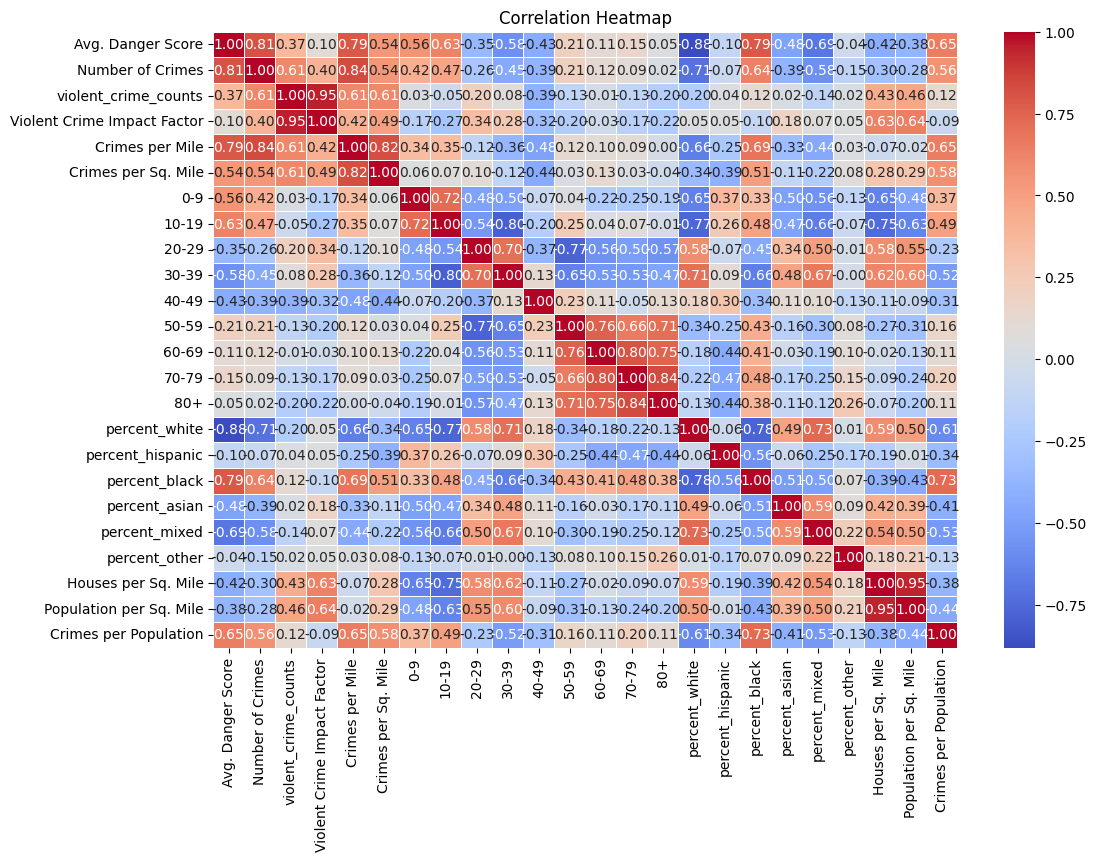

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the features to correlate
selected_features = ['Avg. Danger Score', 'Number of Crimes', 'violent_crime_counts', 'Violent Crime Impact Factor',
                'Crimes per Mile', 'Crimes per Sq. Mile', '0-9', '10-19', '20-29',
                '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'percent_white', 'percent_hispanic',
                'percent_black', 'percent_asian', 'percent_mixed', 'percent_other',
                'Houses per Sq. Mile', 'Population per Sq. Mile', 'Crimes per Population']
subset_df_sector = df_sector[selected_features]

# Calculate the correlation matrix
correlation_matrix = subset_df_sector.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [67]:
# Find features with a strong correlation with 'Avg. Danger Score'
strong_correlations = correlation_matrix['Avg. Danger Score'][
    (correlation_matrix['Avg. Danger Score'].abs() >= 0.6) & (correlation_matrix['Avg. Danger Score'] != 1)
]

# Print the feature names and their correlation values
for feature, corr_value in strong_correlations.items():
    print(f"{feature}: {corr_value}")

Number of Crimes: 0.8093623117373807
Crimes per Mile: 0.7889983283922887
10-19: 0.6274937537713925
percent_white: -0.8813154846962729
percent_black: 0.7911590929649069
percent_mixed: -0.6925206426762
Crimes per Population: 0.6505976875213486


In [68]:
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Identify target to compare to
target = df_sector['Avg. Danger Score']

# Define the features to test
all_features = ['Number of Crimes', 'Crimes per Mile', '10-19', '30-39',
                'percent_white', 'percent_black', 'percent_mixed', 'Crimes per Population']

r2_threshold = 0.7

# Dictionary to store results
results = {}

In [69]:
# Loop over all combination sizes
for i in range(1, len(all_features) + 1):
    for combo in combinations(all_features, i):
        # Select the features in this combination
        features = df_sector[list(combo)]

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

        # Train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Store results if they meet the threshold for strong predictors
        if r2 >= r2_threshold:
            results[combo] = {'R^2 Score': r2, 'MSE': mse}

In [70]:
# Sort the results by R^2 Score (descending) and by combination length (ascending)
sorted_results = sorted(results.items(), key=lambda x: (-x[1]['R^2 Score'], len(x[0])))

# Display the top N results
top_n = 10
print(f"Top {top_n} strongest and most efficient combinations:")
for combo, metrics in sorted_results[:top_n]:
    print(f"Features: {combo}, R^2 Score: {metrics['R^2 Score']:.3f}, MSE: {metrics['MSE']:.3f}")

Top 10 strongest and most efficient combinations:
Features: ('Number of Crimes', 'Crimes per Mile', '10-19', '30-39', 'percent_black'), R^2 Score: 0.899, MSE: 3.028
Features: ('Number of Crimes', 'Crimes per Mile', '10-19', 'percent_black'), R^2 Score: 0.893, MSE: 3.204
Features: ('Number of Crimes', 'Crimes per Mile', '10-19', '30-39', 'percent_white', 'percent_black'), R^2 Score: 0.892, MSE: 3.258
Features: ('Number of Crimes', 'Crimes per Mile', '10-19', 'percent_white', 'percent_black'), R^2 Score: 0.885, MSE: 3.464
Features: ('Number of Crimes', 'Crimes per Mile', 'percent_white', 'percent_black'), R^2 Score: 0.884, MSE: 3.477
Features: ('Number of Crimes', '10-19', '30-39', 'percent_black'), R^2 Score: 0.884, MSE: 3.484
Features: ('Number of Crimes', 'Crimes per Mile', '30-39', 'percent_white', 'percent_black'), R^2 Score: 0.884, MSE: 3.485
Features: ('Number of Crimes', '10-19', '30-39', 'percent_white', 'percent_black'), R^2 Score: 0.877, MSE: 3.693
Features: ('Crimes per Mile'

In [71]:
best_features = []
best_r2 = 0
remaining_features = all_features.copy()
threshold_improvement = 0.01

# Adds features to the combination until there is not a significant improvement
while remaining_features:
    best_new_feature = None
    for feature in remaining_features:
        combo = best_features + [feature]
        X = df_sector[combo]
        X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2 + threshold_improvement:
            best_r2 = r2
            best_new_feature = feature

    if best_new_feature:
        best_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
    else:
        break  # Stop if no significant improvement

print("Best feature combination using forward selection:", best_features)
print(f"R^2 Score: {best_r2:.3f}")

Best feature combination using forward selection: ['percent_white', 'Crimes per Mile', 'Number of Crimes', 'percent_black']
R^2 Score: 0.884


In [72]:
from sklearn.linear_model import Lasso

# identify important features by penalizing less useful ones, effectively reducing the number of features in the model

# Adjust alpha to control regularization strength
lasso_model = Lasso(alpha=0.1)
X = df_sector[all_features]
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

lasso_model.fit(X_train, y_train)
lasso_r2 = lasso_model.score(X_test, y_test)

# Get the selected features
selected_features = [feature for feature, coef in zip(all_features, lasso_model.coef_) if coef != 0]
print("Selected features using Lasso:", selected_features)
print(f"Lasso Model R^2 Score: {lasso_r2:.3f}")

Selected features using Lasso: ['Number of Crimes', 'Crimes per Mile', 'percent_white', 'percent_black']
Lasso Model R^2 Score: 0.890


In [73]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define features and target
features = ['Number of Crimes', '10-19', '30-39', 'percent_black', 'percent_mixed']
X = df_sector[features]
y = df_sector['Avg. Danger Score']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
# Initialize a basic Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = dt_reg.predict(X_test)
print(f"Default Decision Tree R^2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"Default Decision Tree MSE: {mean_squared_error(y_test, y_pred):.3f}")

Default Decision Tree R^2 Score: 0.692
Default Decision Tree MSE: 9.248


In [75]:
# Perform GridSearchCV for hyperparameter tuning
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters from GridSearchCV:", best_params)
print(f"Best Cross-Validated R^2 Score: {best_score:.3f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters from GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validated R^2 Score: 0.598


In [76]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

print(f"Test Set R^2 Score with Best Model: {r2_score(y_test, y_test_pred):.3f}")
print(f"Test Set MSE with Best Model: {mean_squared_error(y_test, y_test_pred):.3f}")

Test Set R^2 Score with Best Model: 0.307
Test Set MSE with Best Model: 20.851


In [77]:
# Define current best features and the remaining features
current_best_features = ['Number of Crimes', '10-19', '30-39', 'percent_black', 'percent_mixed']
remaining_features = [feature for feature in selected_features if feature not in current_best_features + ['Avg. Danger Score', 'SAFETY']]

In [78]:
# Function to evaluate a model with a given set of features
def evaluate_model(features):
    X = df_sector[features]
    y = df_sector['Avg. Danger Score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = DecisionTreeRegressor(random_state=42, max_depth=6, max_features='sqrt', min_samples_leaf=1, min_samples_split=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return r2, mse

In [79]:
# Evaluate the current best model
best_r2, best_mse = evaluate_model(current_best_features)
print(f"Initial Model - R^2: {best_r2:.3f}, MSE: {best_mse:.3f}")

Initial Model - R^2: 0.441, MSE: 16.808


In [80]:
# Loop through remaining features and evaluate
for feature in remaining_features:
    new_features = current_best_features + [feature]
    r2, mse = evaluate_model(new_features)
    print(f"Adding '{feature}' - R^2: {r2:.3f}, MSE: {mse:.3f}")

    # Update the best model if there's an improvement
    if r2 > best_r2:
        print(f"Improvement found by adding '{feature}'!")
        best_r2, best_mse = r2, mse
        current_best_features.append(feature)

# Final model features and performance
print("\nFinal Model Features:", current_best_features)
print(f"Final Model - R^2: {best_r2:.3f}, MSE: {best_mse:.3f}")

Adding 'Crimes per Mile' - R^2: 0.805, MSE: 5.850
Improvement found by adding 'Crimes per Mile'!
Adding 'percent_white' - R^2: 0.738, MSE: 7.865

Final Model Features: ['Number of Crimes', '10-19', '30-39', 'percent_black', 'percent_mixed', 'Crimes per Mile']
Final Model - R^2: 0.805, MSE: 5.850


In [81]:
# Add a new feature as a combination of log-transformed values
df_sector['Log Combined Crimes'] = np.log1p(df_sector['Number of Crimes']) + np.log1p(df_sector['Crimes per Mile'])

In [82]:
# Train the final model with the selected features
final_features = ['Log Combined Crimes', '10-19', '30-39', 'percent_black', 'percent_mixed', 'percent_white']
X_final = df_sector[final_features]
y_final = df_sector['Avg. Danger Score']

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

# Train the Decision Tree Regressor
final_model = DecisionTreeRegressor(max_depth=6, max_features='sqrt', min_samples_split=5, min_samples_leaf=1, random_state=42)
final_model.fit(X_train_final, y_train_final)

DecisionTreeRegressor(max_depth=6, max_features='sqrt', min_samples_split=5,
                      random_state=42)

In [83]:
# Evaluate the final model
y_pred_final = final_model.predict(X_test_final)
final_r2 = r2_score(y_test_final, y_pred_final)
final_mse = mean_squared_error(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)

print(f"Final Model - R^2: {final_r2:.3f}")
print(f"Final Model - MSE: {final_mse:.3f}")
print(f"Decision Tree Mean Absolute Error (MAE): {mae:.3f}")

Final Model - R^2: 0.800
Final Model - MSE: 6.018
Decision Tree Mean Absolute Error (MAE): 1.726


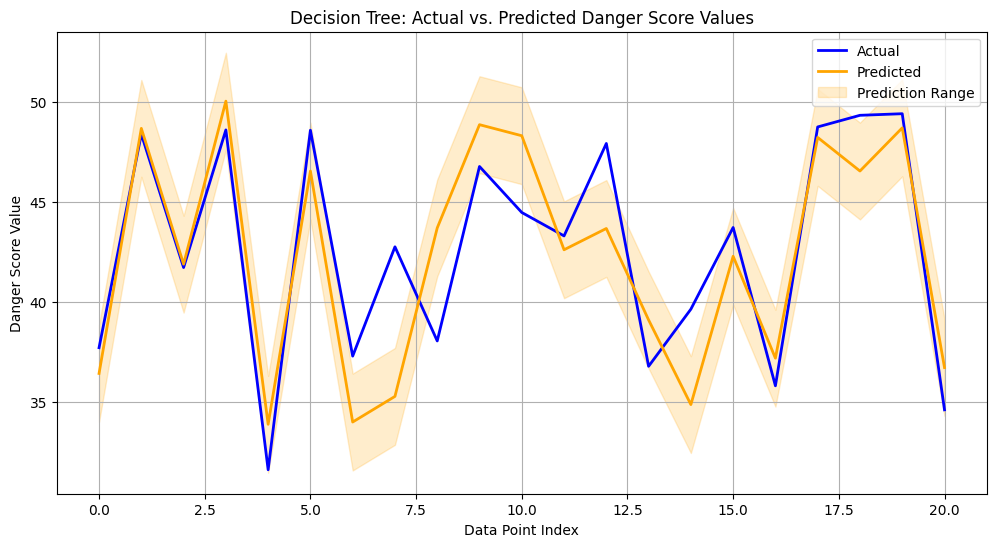

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

# Make predictions using the Decision Tree model
y_pred = dt_reg.predict(X_test)

# Calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})

# Add upper and lower bounds based on MAE
results_df['Upper_Bound'] = results_df['Predicted'] + mae
results_df['Lower_Bound'] = results_df['Predicted'] - mae

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(results_df['Predicted'], label='Predicted', color='orange', linewidth=2)

plt.fill_between(results_df.index,
                 results_df['Lower_Bound'],
                 results_df['Upper_Bound'],
                 color='orange', alpha=0.2, label='Prediction Range')

plt.title("Decision Tree: Actual vs. Predicted Danger Score Values")
plt.xlabel("Data Point Index")
plt.ylabel("Danger Score Value")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [86]:
X = df_sector[['Log Combined Crimes', '10-19', '30-39', 'percent_black', 'percent_mixed', 'percent_white']]
y = df_sector['Avg. Danger Score']

In [87]:
# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Build the model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(1))

In [89]:
# Compile the model with Adam optimizer and MSE loss
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [90]:
history = model.fit(X_train, y_train, epochs=30, batch_size=24, validation_split=0.2, verbose=1)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - loss: 1706.5565 - mae: 40.8990 - val_loss: 1790.1028 - val_mae: 41.9363
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1693.4495 - mae: 40.7637 - val_loss: 1763.1440 - val_mae: 41.6160
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1668.1974 - mae: 40.4152 - val_loss: 1730.4618 - val_mae: 41.2242
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1648.3396 - mae: 40.2216 - val_loss: 1691.1313 - val_mae: 40.7477
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1618.1604 - mae: 39.7994 - val_loss: 1643.5067 - val_mae: 40.1636
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1536.4884 - mae: 38.7786 - val_loss: 1584.5101 - val_mae: 39.4282
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1476.8970 - mae: 38.0114 - val_loss: 1512.0073 - val_mae: 38.5051
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1441.0598 - mae: 37.5721 - val_loss: 1424.4025 - val_mae: 37.3596
Epoch 9/30
2/2 

In [91]:
# Set up callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [92]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Absolute Error: {mae}")

# Predict on the test set
y_pred = model.predict(X_test).flatten()

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Output the metrics
print(f"Test Mean Squared Error (MSE): {mse}")
print(f"Test R² Score: {r2}")

Test Mean Absolute Error: 3.997631549835205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Test Mean Squared Error (MSE): 21.369953002620072
Test R² Score: 0.216840211455387


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


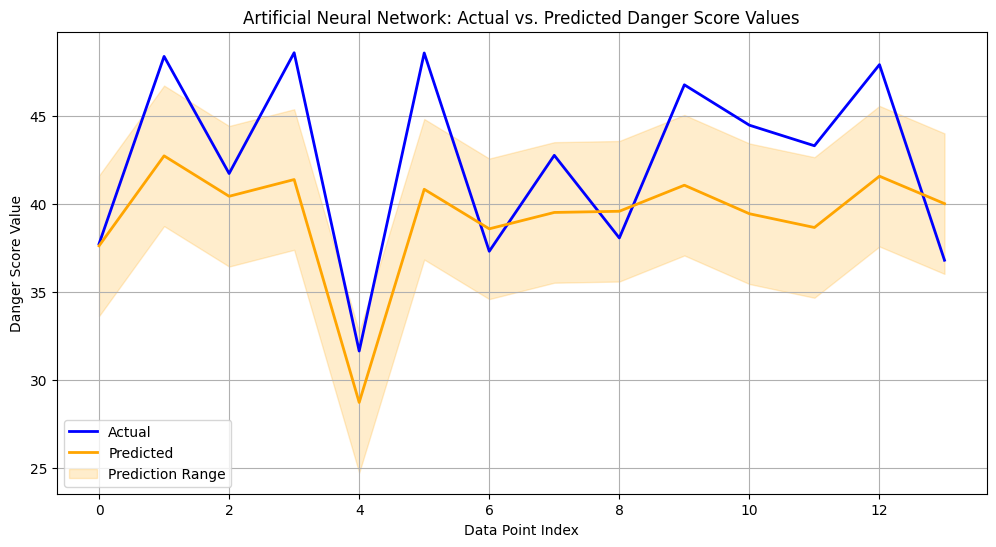

In [93]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred.flatten()})

results_df['Upper_Bound'] = results_df['Predicted'] + mae
results_df['Lower_Bound'] = results_df['Predicted'] - mae

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(results_df['Predicted'], label='Predicted', color='orange', linewidth=2)

plt.fill_between(results_df.index,
                 results_df['Lower_Bound'],
                 results_df['Upper_Bound'],
                 color='orange', alpha=0.2, label='Prediction Range')

plt.title("Artificial Neural Network: Actual vs. Predicted Danger Score Values")
plt.xlabel("Data Point Index")
plt.ylabel("Danger Score Value")
plt.legend()
plt.grid(True)
plt.show()